# A/B Test Design and Results Analysis for an Entertainment App

- **Author**: Ekaterina Kemenova
- **Date**: 05.01.2026

## 0.1 Project goals and objectives

**Goal:**  
To design an A/B test for a new recommendation algorithm in an entertainment app with an infinite content feed and to analyze the results of the experiment.

**Context:**  
The app operates under two monetization models: a monthly paid subscription that allows users to browse the feed without advertisements, and advertising shown to non-subscribed users. A new recommendation algorithm was developed with the expectation that it would surface more engaging content and improve user behavior metrics. The task of this project is to evaluate this hypothesis through a controlled A/B experiment.

**Key objectives:**
- Perform EDA on historical data to validate data quality and establish baseline metrics;
- Design A/B test parameters (primary metric, hypothesis, sample size, test duration);
- Monitor early experiment health and validate experiment correctness;
- Analyze A/B test results: evaluate the impact of the new recommendation algorithm on the primary metric and test statistical significance;
- Provide data-driven recommendations based on the observed effects.
---

## 0.2 Data description

The analysis is based on three datasets:

- **sessions_project_history.csv** — historical user session data for the period from *2025-08-11* to *2025-09-23*. 

- **sessions_project_test_part.csv** — data for the first day of the A/B test (*2025-10-14*).  

- **sessions_project_test.csv** — data for the full A/B test period from *2025-10-14* to *2025-11-02*.

All datasets have a similar structure and differ only in the observation period.

**Dataset columns:**
- `user_id` — unique user identifier;
- `session_id` — unique session identifier;
- `session_date` — session date;
- `session_start_ts` — session start timestamp;
- `install_date` — application install date;
- `session_number` — sequential session number for a given user;
- `registration_flag` — whether the user is registered;
- `page_counter` — number of pages viewed during the session;
- `region` — user region;
- `device` — user device type;
- `test_group` — experiment group (not present in the historical dataset).

## 0.3 Project structure

1. [EDA of historical data and baseline metrics](#historical-data-exploration-and-baseline-metrics)
2. [A/B test design](#ab-test-design-and-planning)
3. [Experiment monitoring and validation](#experiment-monitoring-and-validation)
4. [A/B test results analysis](#ab-test-results-analysis)
5. [Conclusions and recommendations](#conclusions-and-recommendations)

<a id='historical-data-exploration-and-baseline-metrics'></a>
## 1. EDA of historical data and baseline metrics
### 1.1 Data loading and initial exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history = pd.read_csv('sessions_project_history.csv')

In [3]:
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


For each unique user `user_id`, we calculate the number of unique sessions `session_id`.

In [5]:
sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending=False)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [6]:
sessions_history[sessions_history['user_id'] == '10E0DEFC1ABDBBE0']

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.2 Analysis of the number of registered users

We calculate and visualize how the number of unique users and registered users changes for each day of observation:

In [7]:
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

In [8]:
sessions_history_agg = sessions_history.groupby('session_date').agg(users_total=('user_id','nunique'),users_registered=('registration_flag','sum')).reset_index().sort_values(by='session_date')
sessions_history_agg

,session_date,users_total,users_registered
0,2025-08-11,3919,169
1,2025-08-12,6056,336
2,2025-08-13,8489,464
3,2025-08-14,10321,625
4,2025-08-15,14065,840
5,2025-08-16,12205,916
6,2025-08-17,11200,833
7,2025-08-18,10839,860
8,2025-08-19,12118,831
9,2025-08-20,13514,1008


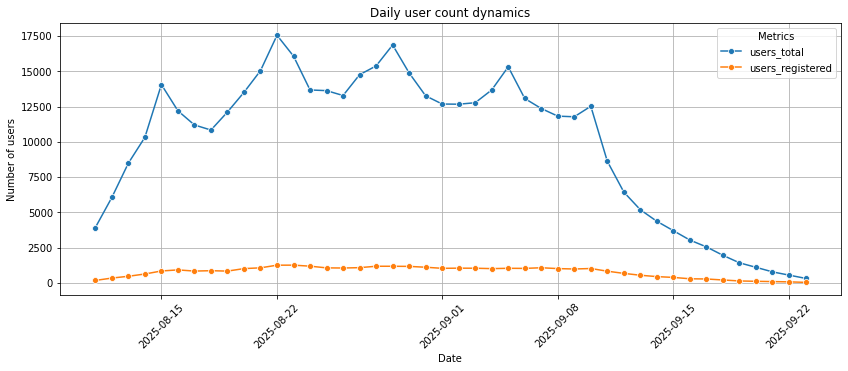

In [9]:
plt.figure(figsize=(14,5))

sns.lineplot(
    data=sessions_history_agg,
    x='session_date',
    y='users_total',
    label='users_total',
    marker='o'
)

sns.lineplot(
    data=sessions_history_agg,
    x='session_date',
    y='users_registered',
    label='users_registered',
    marker='o'
)

plt.title('Daily user count dynamics')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

In [10]:
sessions_history_agg['registration_share']=sessions_history_agg['users_registered'] / sessions_history_agg['users_total']

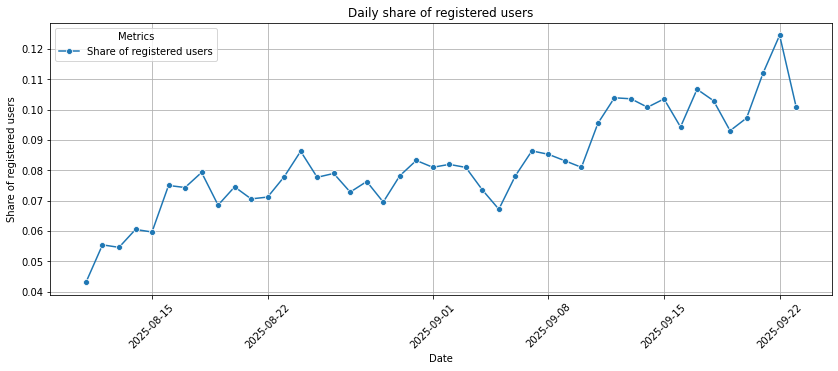

In [11]:
plt.figure(figsize=(14,5))

sns.lineplot(
    data=sessions_history_agg,
    x='session_date',
    y='registration_share',
    label='Share of registered users',
    marker='o')

plt.title('Daily share of registered users')
plt.xlabel('Date')
plt.ylabel('Share of registered users')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

The total number of users and registered users shows a similar overall trend, with growth during the early period followed by a gradual decline toward the end of the observation window. At the same time, the share of registered users demonstrates an overall upward trend, indicating that despite decreasing traffic a higher proportion of users choose to register over time.

#### 1.3 Analysis of the number of page views

The more pages a user views, the higher their engagement with the content, and consequently the higher the likelihood of registration and subscription. 

We calculate the number of sessions for each page view count:

In [12]:
sessions_history_agg_pages = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index()
sessions_history_agg_pages

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


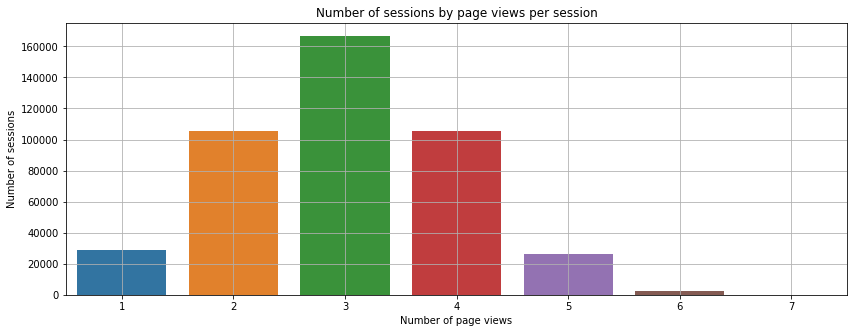

In [13]:
plt.figure(figsize=(14,5))

sns.barplot(
    data=sessions_history_agg_pages,
    x='page_counter',
    y='session_id')

plt.title('Number of sessions by page views per session')
plt.xlabel('Number of page views')
plt.ylabel('Number of sessions')
plt.grid()
plt.show()

Most sessions involve viewing 3 pages, followed by sessions with 2 and 4 pages, while sessions with very low (1 page) or very high (6+ pages) page views are relatively rare, indicating that moderate engagement levels are most common.

#### 1.4. Share of sessions with 4+ page views
The product team considers sessions in which a user views 4 or more pages to indicate satisfaction with the content and recommendation algorithm. 

We create an additional `good_session` column (set to 1 if a session includes 4 or more page views and 0 otherwise) and visualize the daily share of successful (good) sessions:

In [14]:
def classify_good_session(row):
    if row['page_counter'] >= 4:
        return 1
    else:
        return 0
    
sessions_history['good_session'] = sessions_history.apply(classify_good_session, axis = 1)

In [15]:
sessions_history_agg_good_sessions = sessions_history.groupby('session_date').agg(total_sessions=('session_id','nunique'),good_sessions=('good_session','sum')).reset_index().sort_values(by='session_date')
sessions_history_agg_good_sessions['good_session_share'] = sessions_history_agg_good_sessions['good_sessions'] / sessions_history_agg_good_sessions['total_sessions']
sessions_history_agg_good_sessions 

,session_date,total_sessions,good_sessions,good_session_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941
5,2025-08-16,12205,3737,0.306186
6,2025-08-17,11200,3557,0.317589
7,2025-08-18,10839,3366,0.310545
8,2025-08-19,12118,3791,0.312840
9,2025-08-20,13514,4148,0.306941


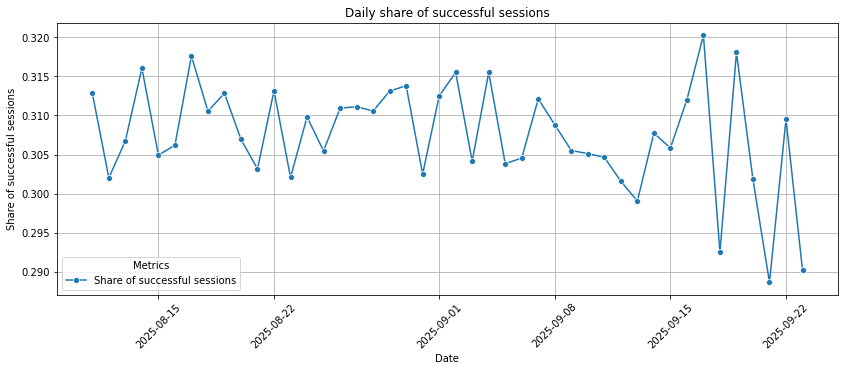

In [16]:
plt.figure(figsize=(14,5))

sns.lineplot(
    data=sessions_history_agg_good_sessions,
    x='session_date',
    y='good_session_share',
    label='Share of successful sessions',
    marker='o')

plt.title('Daily share of successful sessions')
plt.xlabel('Date')
plt.ylabel('Share of successful sessions')
plt.grid()
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

The share of successful sessions remains relatively stable over time with noticeable day-to-day fluctuations, suggesting consistent user engagement levels.

The exploratory analysis of historical data shows that user engagement patterns are stable over time. While total traffic and absolute registrations decline toward the end of the observation period, the share of registered users gradually increases. Most sessions involve a moderate number of page views (2-4 pages), and the share of successfull sessions (4+ page views) remains consistently stable, providing a reliable baseline for A/B test design and evaluation.

<a id='ab-test-design-and-planning'></a>
### 2. A/B test design

#### 2.1 Defining the null and alternative hypotheses

As the primary metric, we use **the share of successful sessions** (i.e., sessions in which a user views 4 or more pages), as this metric reflects content engagement and captures the effect of the recommendation algorithm.

- H0: The share of successful sessions does not change after the introduction of the new recommendation algorithm.
- H1: The share of successful sessions changes after the introduction of the new recommendation algorithm.

#### 2.2. Calculating the sample size

In [17]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

alpha = 0.05
beta = 0.2
power = 0.8
p = 0.3
mde = 0.03 * p
effect_size = proportion_effectsize(p, p + mde)

power_analysis = NormalIndPower()

sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1
)

print(f'Required sample size per group: {int(sample_size)}')

Required sample size per group: 41040


#### 2.3. Calculating A/B test duration

We calculate the average daily number of unique users and estimate the test duration based on the required sample size and the average daily traffic:

In [37]:
from math import ceil

avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

test_duration = ceil(41040*2 / avg_daily_users)

print(f'Estimated A/B test duration at the current traffic level of {avg_daily_users:.0f} users per day is {test_duration} days')

Estimated A/B test duration at the current traffic level of 9907 users per day is 9 days


<a id='experiment-monitoring-and-validation'></a>
### 3. Experiment monitoring and validation

#### 3.1.Checking user distribution

Based on the first day of A/B test data, we verify that the experiment is running correctly. 

We calculate the number of unique users in each experimental group and the percentage difference between them:

In [38]:
sessions_test_part = pd.read_csv('sessions_project_test_part.csv')

In [39]:
sessions_test_part_groups = sessions_test_part.groupby(['session_date','test_group'])['user_id'].nunique().reset_index()
sessions_test_part_groups

,session_date,test_group,user_id
0,2025-10-14,A,1477
1,2025-10-14,B,1466


In [40]:
pivot = sessions_test_part_groups.pivot(index='session_date', columns='test_group', values='user_id')
pivot['percent_difference'] = 100 * (pivot['A'] - pivot['B']) / pivot['A'] 
pivot

test_group,A,B,percent_difference
session_date,,,
2025-10-14,1477,1466,0.744753


The percentage difference in the number of users between groups A and B is 0.7%, indicating balanced group sizes.

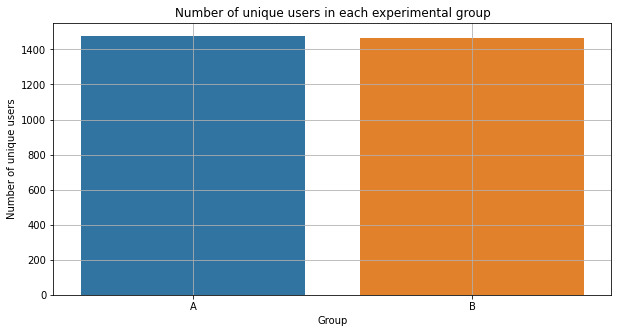

In [41]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=sessions_test_part_groups,
    x='test_group',
    y='user_id')

plt.title('Number of unique users in each experimental group')
plt.xlabel('Group')
plt.ylabel('Number of unique users')
plt.grid()
plt.show()

#### 3.2. Checking for user overlaps

We verify that the groups are independent and that no users appear in both groups A and B:

In [42]:
sessions_test_part.groupby('user_id')['test_group'].nunique().reset_index().sort_values(by='test_group',ascending=False)

,user_id,test_group
0,00079359B9D3C6F7,1
1955,ADC2E1E1158CFBB2,1
1957,ADCEEDAD20F4782F,1
1958,ADDCDDC883993FA6,1
1959,AE072C4F9B473BCD,1
...,...,...
983,54C3FA4C32B6ABBA,1
984,54F28A45A5E77DB8,1
985,54FF42B690A9B2E5,1
986,55529D5E3198D24D,1


No user overlap between groups A and B was detected, confirming group independence.

#### 3.3. Device type distribution across groups

We verify that users are evenly distributed across categorical variables, including device types and regions:

In [43]:
sessions_test_part.groupby(['test_group','device'])['user_id'].nunique()

test_group  device 
A           Android    656
            Mac        156
            PC         369
            iPhone     296
B           Android    668
            Mac        148
            PC         381
            iPhone     269
Name: user_id, dtype: int64

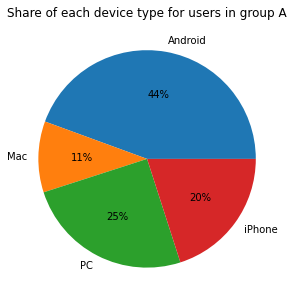

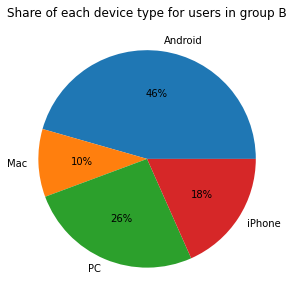

In [44]:
plt.figure (figsize = (10,5))

sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each device type for users in group A',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

plt.figure (figsize = (10,5))

sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().plot(
    kind='pie',
    title='Share of each device type for users in group B',
    autopct='%.0f%%',
    ylabel=''
)

plt.show()

#### 3.4. Regional distribution across groups

In [45]:
region_agg_A = sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().reset_index()
region_agg_A['share'] = region_agg_A['user_id'] / region_agg_A['user_id'].sum()
region_agg_A

,region,user_id,share
0,CIS,644,0.436019
1,EU,224,0.151659
2,MENA,609,0.412322


In [46]:
region_agg_B = sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().reset_index()
region_agg_B['share'] = region_agg_B['user_id'] / region_agg_B['user_id'].sum()
region_agg_B

,region,user_id,share
0,CIS,645,0.439973
1,EU,217,0.148022
2,MENA,604,0.412005


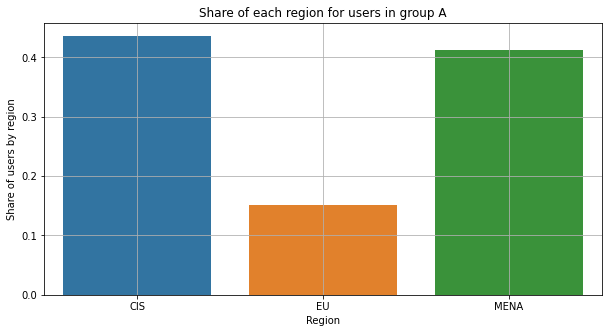

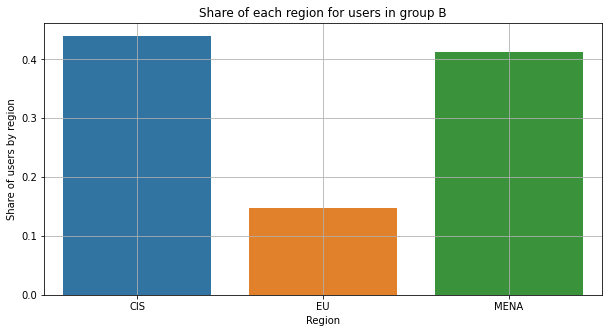

In [47]:
plt.figure(figsize=(10,5))

sns.barplot(
    data=region_agg_A,
    x='region',
    y='share')

plt.title('Share of each region for users in group A')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylabel('Share of users by region')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))

sns.barplot(
    data=region_agg_B,
    x='region',
    y='share')

plt.title('Share of each region for users in group B')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylabel('Share of users by region')
plt.grid()
plt.show()

#### 3.5. Summary of A/B test validation

The A/B test is conducted correctly. The groups are comparable in terms of the number of unique users, with a percentage difference of less than 1% (0.7%). The samples are independent, as no user overlap between the control and test groups was detected. User distributions across categorical variables (device type and region) are balanced between the two groups.

<a id='ab-test-results-analysis'></a>
### 4. A/B test results analysis

#### 4.1. Retrieving test results and calculating the primary metric

In [48]:
sessions_test = pd.read_csv('sessions_project_test.csv')

In [49]:
sessions_test['good_session'] = sessions_test.apply(classify_good_session, axis = 1)

#### 4.2. Validating test results

We verify that the daily number of unique sessions does not differ significantly between the two samples:

In [50]:
sessions_test_agg = sessions_test.groupby(['session_date','test_group'])['session_id'].nunique().reset_index()
sessions_test_agg

,session_date,test_group,session_id
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241
6,2025-10-17,A,4089
7,2025-10-17,B,4054
8,2025-10-18,A,5013
9,2025-10-18,B,5059


In [51]:
sample_1 = sessions_test_agg[sessions_test_agg['test_group'] == 'A']['session_id']
sample_2 = sessions_test_agg[sessions_test_agg['test_group'] == 'B']['session_id']

alpha = 0.05

results = st.ttest_ind(
    sample_1,
    sample_2)

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

P-value: 0.938219304859116
Fail to reject the null hypothesis


We recheck the results using the Mann–Whitney U test to account for potential data anomalies:

In [52]:
sample_1 = sessions_test_agg[sessions_test_agg['test_group'] == 'A']['session_id']
sample_2 = sessions_test_agg[sessions_test_agg['test_group'] == 'B']['session_id']

alpha = 0.05

results = st.mannwhitneyu(
    sample_1,
    sample_2)

print('P-value:', results.pvalue)

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

P-value: 0.8817307917391243
Fail to reject the null hypothesis


We fail to reject the null hypothesis, indicating no statistically significant difference in the average number of unique sessions between the two groups.

#### 4.3. Comparison of the share of successful sessions

We calculate the share of successful sessions for groups A and B, as well as the difference between them:

In [53]:
sessions_test_good_agg = sessions_test.groupby('test_group').agg(total_sessions=('session_id','nunique'),good_sessions=('good_session','sum')).reset_index()
sessions_test_good_agg['share'] = sessions_test_good_agg['good_sessions'] / sessions_test_good_agg['total_sessions']
sessions_test_good_agg

,test_group,total_sessions,good_sessions,share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


In [54]:
share_A = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'A']['share'].iloc[0]

share_B = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'B']['share'].iloc[0]

percent_diff = 100 * (share_B - share_A) / share_A

print(
    f'Share of successful sessions in group A: {share_A:.3f}\n'
    f'Share of successful sessions in group B: {share_B:.3f}\n'
    f'Relative difference (B vs A): {percent_diff:.2f}%'
)

Share of successful sessions in group A: 0.308
Share of successful sessions in group B: 0.318
Relative difference (B vs A): 3.43%


#### 4.4. Assessing statistical significance of the primary metric change

Using a two-proportion z-test, we assess whether the change in the share of successful sessions is statistically significant:

In [58]:
good_sessions_A = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'A']['good_sessions'].iloc[0]
good_sessions_B = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'B']['good_sessions'].iloc[0]
total_sessions_A = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'A']['total_sessions'].iloc[0]
total_sessions_B = sessions_test_good_agg[sessions_test_good_agg['test_group'] == 'B']['total_sessions'].iloc[0]

alpha = 0.05

z_score, p_value = proportions_ztest([good_sessions_A, good_sessions_B],[total_sessions_A, total_sessions_B], alternative='two-sided')

print('P-value:', p_value)

if (p_value < alpha):
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

P-value: 0.0003149479976072246
Reject the null hypothesis


We reject the null hypothesis; therefore, a statistically significant change in the share of successful sessions is observed.

<a id='conclusions-and-recommendations'></a>
### 5. Conclusions and recommendations

We conducted an A/B test involving 41,040 users in both the control and test groups over a period of 9 days. The experiment was conducted correctly: the groups are comparable in terms of unique user counts, the samples are independent, and user distributions across categorical variables are balanced.

The primary metric was the share of successful sessions (i.e., sessions in which a user viewed 4 or more pages). The following hypotheses were tested:
- H0: The share of successful sessions does not change after the introduction of the new recommendation algorithm.
- H1: The share of successful sessions changes after the introduction of the new recommendation algorithm.

The results show a statistically significant change in the primary metric, allowing us to reject the null hypothesis (p-value = 0.0003 < 0.05).

The observed effect is positive: the share of successful sessions in the test group is approximately 1.1 percentage points higher than in the control group, corresponding to a relative increase of 3.43%.

Therefore, we conclude that the introduction of the new recommendation algorithm leads to a **statistically significant increase in the share of successful sessions**, and we recommend considering its rollout in the product.